# Comparison AA with NMF

In [107]:
import partipy as pt
import scanpy as sc
import decoupler as dc
import plotnine as pn
import pandas as pd
import numpy as np
from partipy.datasets import load_hepatocyte_data
from sklearn.decomposition import NMF
from scipy.stats import spearmanr
from scipy.optimize import linear_sum_assignment
import patchworklib as pw

## Load Data and run NMF

First load the hepaocyte data, normalize and log transform as usual.

In [108]:
adata = load_hepatocyte_data()
adata

AnnData object with n_obs × n_vars = 1534 × 10400
    obs: 'batch', 'seq_batch_ID', 'plate_coordinates', 'pool_barcode', 'cell_barcode', 'plate', 'subject'

In [109]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata)

Subset for only the highly variable genes

In [110]:
X = adata.X[: , adata.var.highly_variable]

In [111]:
nmf = NMF(n_components=3, random_state=42)

In [112]:
W = nmf.fit_transform(X)
H = nmf.components_

## Visual Comparison Archetypes vs. W

Loading the hepatocye data 

In [7]:
adatarun = sc.read_h5ad("DataAnalysis/adata_HepRun.h5ad")
X_pca = adatarun.obsm["X_pca"] 

In [ ]:
p0 = pt.plot_2D(X_pca, adatarun.uns["AA_results"]["Z"], color_vec=W[:, 0], size= 1, show_two_panels=True) + pn.theme_matplotlib()
p0 = pw.load_ggplot(p0, figsize=(14, 5))
p0.set_index("A", fontsize = 30)

p1 = pt.plot_2D(X_pca, adatarun.uns["AA_results"]["Z"], color_vec=W[:, 1], size= 1, show_two_panels=True) + pn.theme_matplotlib()
p1 = pw.load_ggplot(p1, figsize=(14, 5))
p1.set_index("B", fontsize = 30)

p2 = pt.plot_2D(X_pca, adatarun.uns["AA_results"]["Z"], color_vec=W[:, 2], size= 1, show_two_panels=True) + pn.theme_matplotlib()
p2 = pw.load_ggplot(p2, figsize=(14, 5))
p2.set_index("C", fontsize = 30)

2025-06-05 14:37:13 | [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


2025-06-05 14:37:14 | [INFO] maxp pruned
2025-06-05 14:37:14 | [INFO] cmap pruned
2025-06-05 14:37:14 | [INFO] kern dropped
2025-06-05 14:37:14 | [INFO] post pruned
2025-06-05 14:37:14 | [INFO] FFTM dropped
2025-06-05 14:37:14 | [INFO] GPOS pruned
2025-06-05 14:37:14 | [INFO] GSUB pruned
2025-06-05 14:37:14 | [INFO] glyf pruned
2025-06-05 14:37:14 | [INFO] Added gid0 to subset
2025-06-05 14:37:14 | [INFO] Added first four glyphs to subset
2025-06-05 14:37:14 | [INFO] Closing glyph list over 'MATH': 32 glyphs before
2025-06-05 14:37:14 | [INFO] Glyph names: ['.notdef', '.null', 'C', 'F', 'P', 'S', 'T', 'c', 'd', 'e', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'six', 'slash', 'space', 't', 'two', 'underscore', 'v', 'x', 'zero']
2025-06-05 14:37:14 | [INFO] Glyph IDs:   [0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 23, 24, 25, 38, 41, 51, 54, 55, 66, 70, 71, 72, 75, 76, 79, 81, 82, 85, 86, 87, 89, 91]
2025-06-05 14:37:14 | [INFO] Closed glyph 

Text(-0.0311969111969112, 1.0210282601572738, 'C')

We can visualize W:

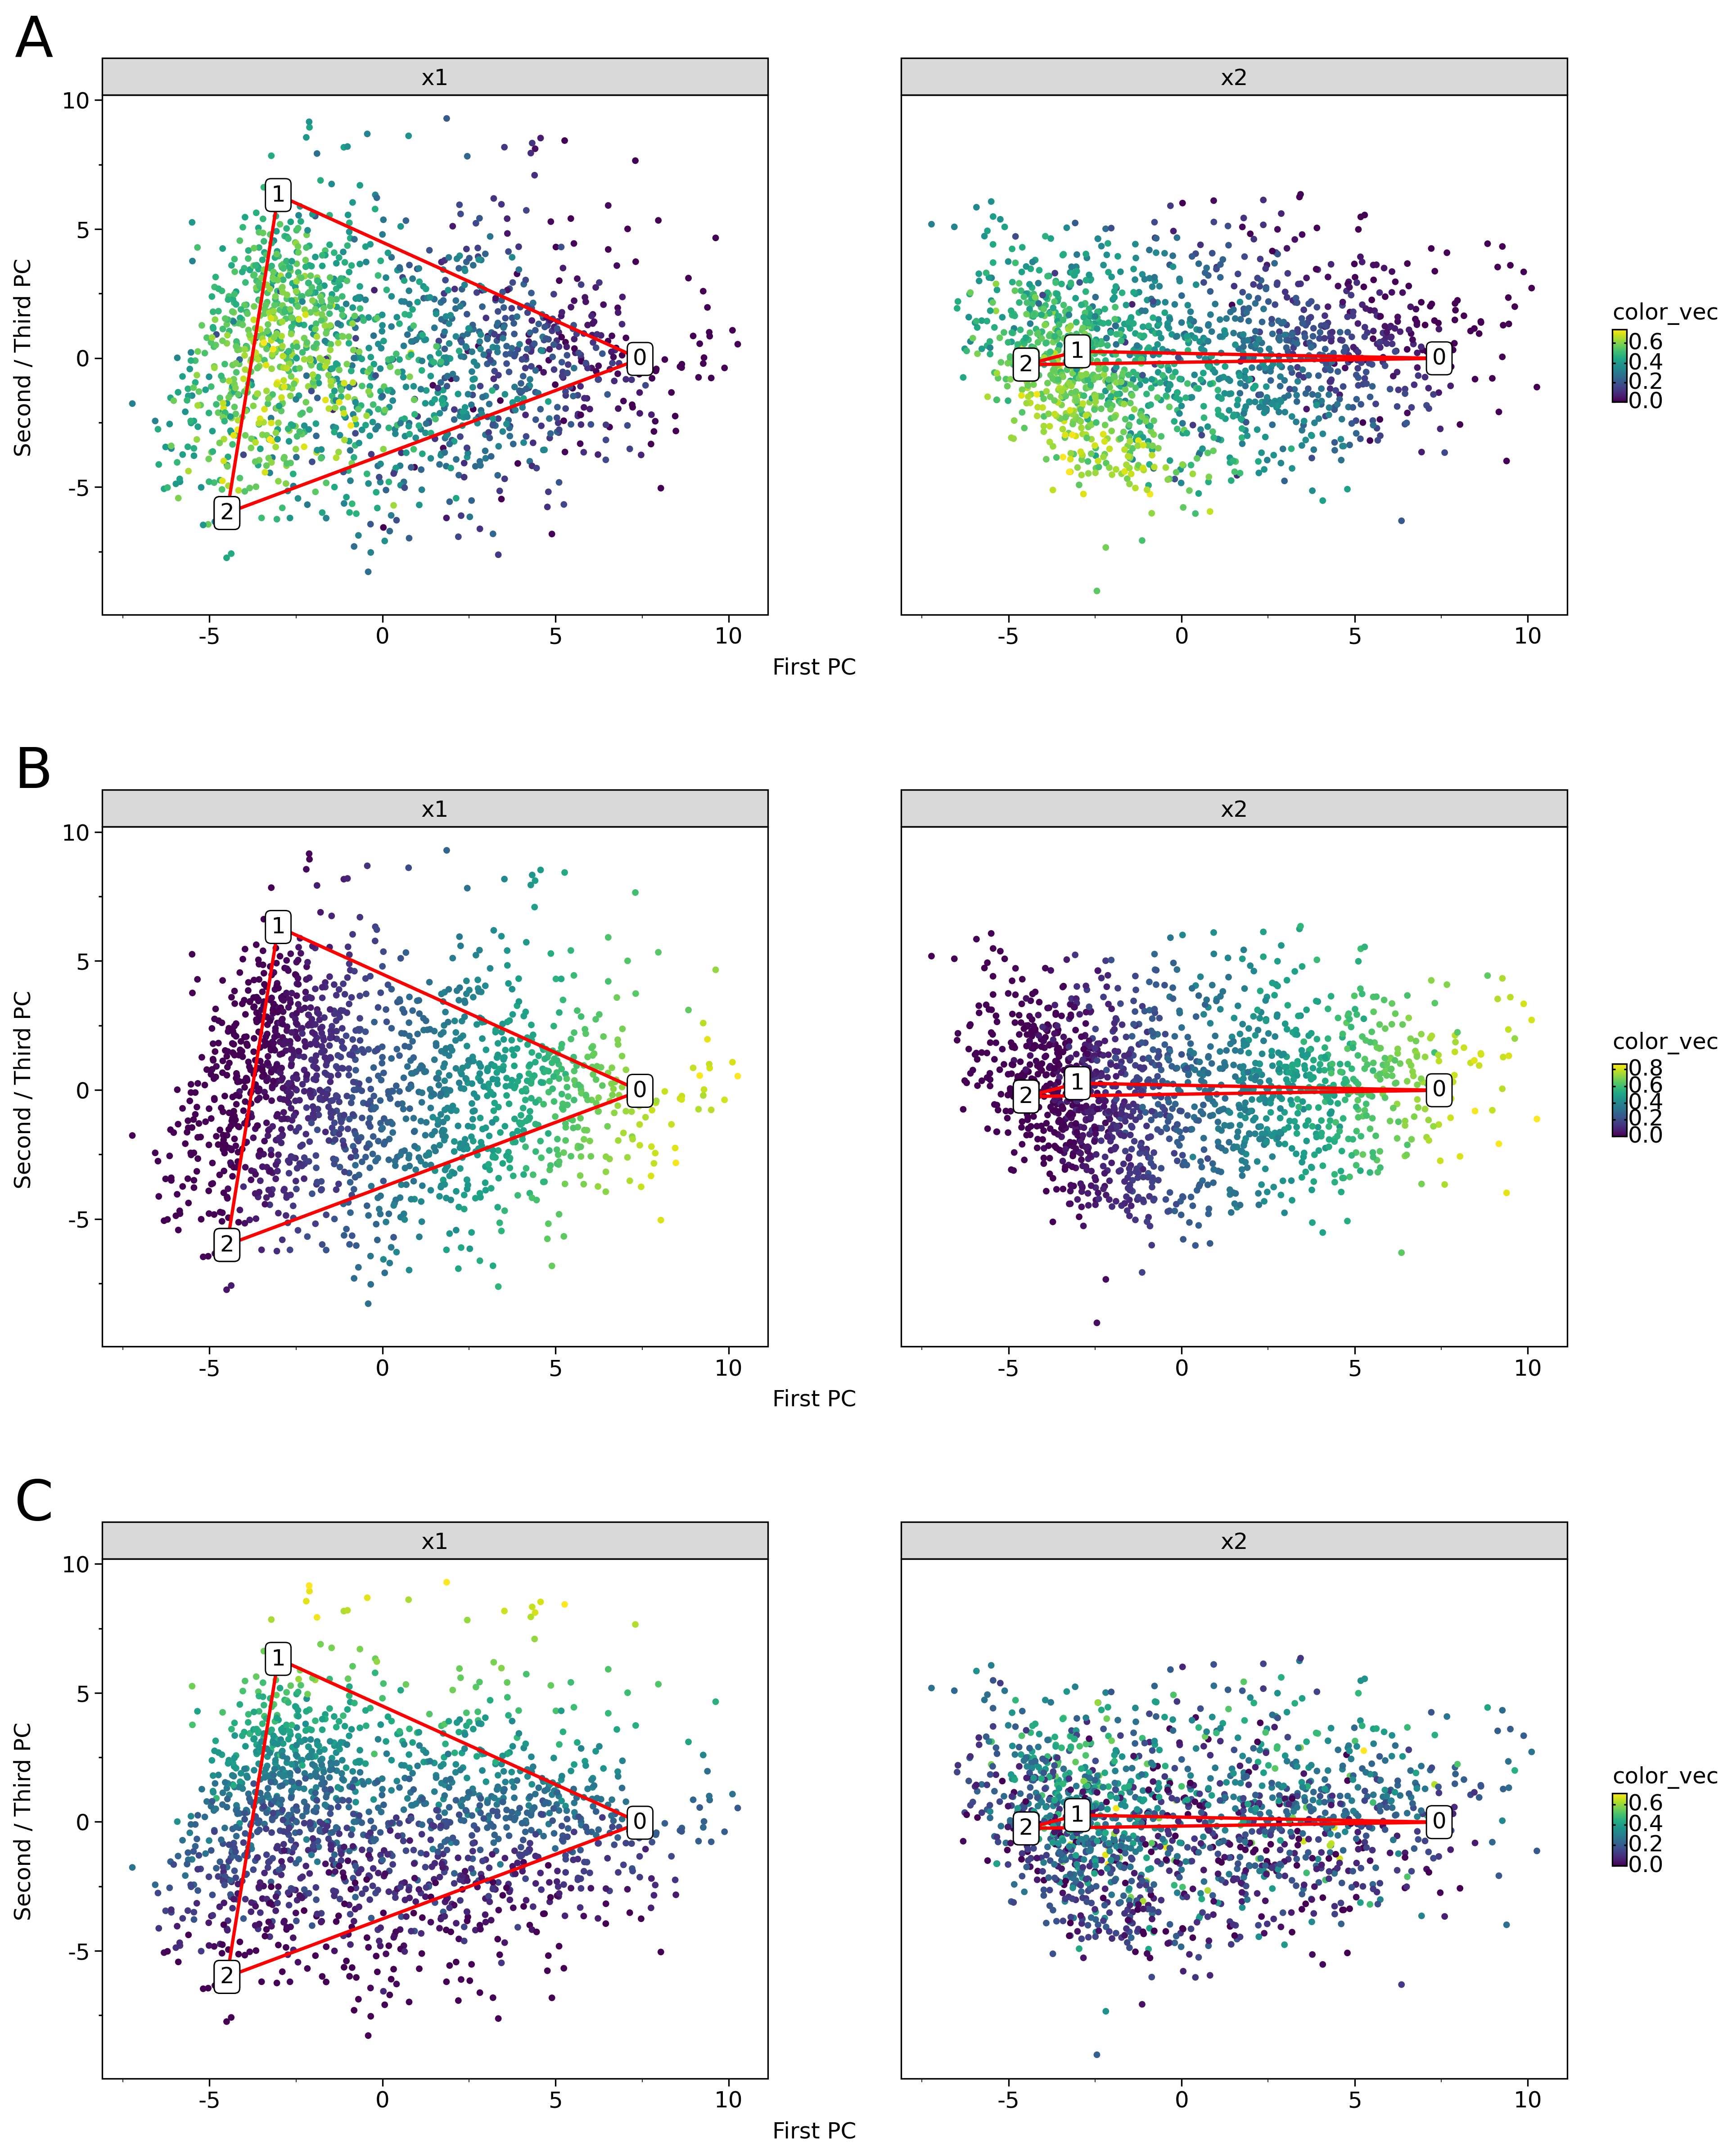

In [10]:
all_p = (p0/p1/p2)
all_p.align_ylabels()
all_p

Important genes for the components, e.g. component 1:

In [117]:
component_genes = pd.DataFrame({"feature": adata.var_names[adata.var.highly_variable], "weight_comp0": H[0], "weight_comp1": H[1], "weight_comp2": H[2]})
component_genes.sort_values(by = "weight_comp2", ascending=False)

,feature,weight_comp0,weight_comp1,weight_comp2
334,B2m,0.837546,1.185285,5.591698
1284,Mug1,0.458496,1.096231,5.273684
1551,Pzp,2.251891,1.982525,4.528768
1858,Tdo2,2.157443,1.851527,4.515038
558,Cps1,1.272730,1.273784,4.355702
...,...,...,...,...
124,AK048257,0.000000,0.024558,0.000000
1768,Snord104,0.083729,0.025531,0.000000
330,B020018G12Rik,0.034553,0.031964,0.000000
126,AK050795,0.012657,0.007972,0.000000


### Correlation

In [12]:
archetype_expression = pt.compute_archetype_expression(adatarun, layer="z_scaled")

In [105]:
arch_expr0 = archetype_expression.loc[:, adata.var.highly_variable].iloc[0].to_numpy()
arch_expr1 = archetype_expression.loc[:, adata.var.highly_variable].iloc[1].to_numpy()
arch_expr2 = archetype_expression.loc[:, adata.var.highly_variable].iloc[2].to_numpy()

Compute spearman correlation between archetype expression profile and the components:

In [14]:
rho, pval = spearmanr(H[1], arch_expr0)
print(f"Spearman r = {rho:.2f}, p = {pval:.2e}")

Spearman r = 0.67, p = 1.36e-275


In [15]:
rho, pval = spearmanr(H[2], arch_expr1)
print(f"Spearman r = {rho:.2f}, p = {pval:.2e}")

Spearman r = 0.67, p = 1.42e-277


Since component 0 is between two archetypes, I compute two correlations:

In [16]:
rho, pval = spearmanr(H[0], arch_expr2)
print(f"Spearman r = {rho:.2f}, p = {pval:.2e}")

Spearman r = -0.10, p = 6.18e-06


In [113]:
rho, pval = spearmanr(H[0], arch_expr1)
print(f"Spearman r = {rho:.2f}, p = {pval:.2e}")

Spearman r = 0.13, p = 4.75e-10


## Jaccard similarity

We can also look at the overlap ot the 100 most important genes per archetype/component:

In [17]:
def jaccard(list1, list2): 
    set1 = set(list1)
    set2 = set(list2)
    # Jaccard = |intersection| / |union|
    jaccard = len(set1 & set2) / len(set1 | set2)
    return jaccard

In [ ]:
top100_genes_arch = []  

for i in range(3):
    genes = (
        archetype_expression
        .loc[:, adata.var.highly_variable]
        .iloc[i]
        .sort_values(ascending=False)
        .index[:100]
        .to_list()
    )
    top100_genes_arch.append(genes)

In [ ]:
top100_genes_comp = []

for i in range(3):
    col_name = f"weight_comp{i}"  
    genes = (
        component_genes
        .sort_values(by=col_name, ascending=False)
        .loc[:, "feature"]
        .head(100)
        .to_list()
    )
    top100_genes_comp.append(genes)

In [ ]:
jaccard(top100_genes_comp[1], top100_genes_arch[0])

0.2987012987012987

In [ ]:
jaccard(top100_genes_comp[2], top100_genes_arch[1])

0.48148148148148145

In [ ]:
jaccard(top100_genes_comp[0], top100_genes_arch[2])

0.11731843575418995

In [ ]:
jaccard(top100_genes_comp[0], top100_genes_arch[1])

0.1834319526627219

## Stability NMF

Here I test the stability of the components/archetypes over multiple initializations with 500 random seeds.

In [52]:
def run_nmf(X, seed, n_components=3):
    nmf = NMF(n_components=n_components, random_state=seed, max_iter = 1000)
    W = nmf.fit_transform(X)
    H = nmf.components_
    return W, H

In [ ]:
seeds = np.random.randint(low=1, high=100000, size=500)
results = []
for i,seed in enumerate(seeds):
    _, H = run_nmf(X, seed)
    print(f"Seed #{i}: {seed}")
    results.append(H)

The components have to be aligned (What is component 1 could be component 2 in the next run)

In [ ]:
reference = results[0]
aligned_results = [reference]

for H in results[1:]:
    
    corr_matrix = np.array([[spearmanr(ref_row, h_row)[0] for h_row in H] for ref_row in reference])
    
    row_ind, col_ind = linear_sum_assignment(-corr_matrix)
    
    aligned_H = H[col_ind]
    aligned_results.append(aligned_H)

And then I calculate the correlation of the components over all runs.

In [56]:
threshold = 0.7
low_corrs = []
all_corrs = []

for k in range(3):  # assuming each result has 3 sub-elements
    for i in range(len(aligned_results)):
        for j in range(i + 1, len(aligned_results)):
            corr, _ = spearmanr(aligned_results[i][k], aligned_results[j][k])
            all_corrs.append(corr)  # store all correlations
            if corr < threshold:
                low_corrs.append({
                    'i': i,
                    'j': j,
                    'k': k,
                    'correlation': corr
                })

# Compute the mean of all correlations
mean_corr = np.mean(all_corrs)
print(f"Mean Spearman correlation: {mean_corr}")

Mean Spearman correlation: 0.9999999995230376


## Stability AA

Same procedure for the archetypes:

In [69]:
def run_AA(adata, k, seed):
    Z = pt.compute_archetypes(adata, k, save_to_anndata=False, seed=seed)
    return Z

In [ ]:
seeds = np.random.randint(low=1, high=100000, size=500)
results_AA = []
for i,seed in enumerate(seeds):
    Z = run_AA(adatarun, 3, seed)
    print(f"Seed #{i}: {seed}")
    results_AA.append(Z)

In [ ]:
reference = results_AA[0]
aligned_results_AA = [reference]

# Align each subsequent H to the reference
for H in results_AA[1:]:
    # Compute pairwise correlation matrix between components
    corr_matrix = np.array([[spearmanr(ref_row, h_row)[0] for h_row in H] for ref_row in reference])
    
    # maximize correlation → minimize -corr
    row_ind, col_ind = linear_sum_assignment(-corr_matrix)
    
    # Reorder H accordingly
    aligned_H = H[col_ind]
    aligned_results_AA.append(aligned_H)

In [ ]:
threshold = 0.7
low_corrs_AA = []
all_corrs_AA = []

for k in range(3):  
    for i in range(len(aligned_results_AA)):
        for j in range(i + 1, len(aligned_results_AA)):
            corr, _ = spearmanr(aligned_results_AA[i][k], aligned_results_AA[j][k])
            all_corrs_AA.append(corr)  
            if corr < threshold:
                low_corrs_AA.append({
                    'i': i,
                    'j': j,
                    'k': k,
                    'correlation': corr
                })

# Compute the mean of all correlations
mean_corr = np.mean(all_corrs_AA)
print(f"Mean Spearman correlation: {mean_corr}")

Mean Spearman correlation: 0.9344978765612031
